# 📊 Model Evaluation — Religious Hate Speech Detection

This notebook evaluates the performance of trained models for religious hate speech detection.

We focus on a deep dive into **metrics, fairness, and failure modes**, using the processed and labeled version of the Civil Comments dataset.

---

## ✅ Goals

- **Load any saved model** for classification (e.g. TinyBERT, DistilBERT, DeBERTa)
- **Evaluate global metrics**: Accuracy, Precision, Recall, F1
- **Visualize** predictions: confusion matrix, ROC, PR curve
- **Analyze errors**: misclassified examples
- **Subgroup Performance**: How does the model perform for each religion?
- **Reusable & Modular**: Easily plug in new models by changing the `save_path`

---

## 🧾 Dataset Assumptions

We assume you have the following CSVs in `../data/`:
- `test_balanced.csv`: test set with `text`, `label`
- Additional test sets (optional): `test.csv`, etc.



In [1]:
# 📦 Imports
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# 📍 Model path (change this to evaluate a different model!)
model_path = "../models/bert-tiny-hate"

# ✅ Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Loaded model from {model_path} on {device}")


✅ Loaded model from ../models/bert-tiny-hate on cpu


## 🧪 Load & Tokenize Test Data

In this section, we load the preprocessed `test_balanced.csv` file which contains religion-related comments labeled as hate (1) or non-hate (0).

We tokenize the text using the same tokenizer used during training and prepare a PyTorch Dataset for evaluation.


In [2]:
# ✅ Load test data
test_df = pd.read_csv("../data/test_balanced.csv")
print(f"📊 Loaded test set with {len(test_df)} samples")
print(test_df['label'].value_counts())

# ✅ Dataset wrapper
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=256)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# ✅ Create test dataset and loader
test_dataset = CommentDataset(test_df["text"], test_df["label"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

print("✅ Tokenization complete and test DataLoader ready.")


📊 Loaded test set with 9614 samples
label
0    8938
1     676
Name: count, dtype: int64
✅ Tokenization complete and test DataLoader ready.


## 📈 Evaluate Model on Test Set

We now pass the test set through the model and collect predictions.  
We'll compute the standard classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 🔍 Inference loop
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📊 Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall:    {recall:.4f}")
print(f"🧠 F1 Score:  {f1:.4f}")


✅ Accuracy:  0.9231
🎯 Precision: 0.4775
🔁 Recall:    0.9882
🧠 F1 Score:  0.6439


## 📊 Confusion Matrix & Classification Report

The confusion matrix helps us understand the types of errors the model makes:

- True Positives: Religious hate correctly detected
- False Positives: Non-hate misclassified as hate
- False Negatives: Hate misclassified as non-hate
- True Negatives: Non-hate correctly detected

We also include the full classification report with class-wise precision, recall, and F1 scores.


📋 Classification Report:
              precision    recall  f1-score   support

    Non-Hate       1.00      0.92      0.96      8938
        Hate       0.48      0.99      0.64       676

    accuracy                           0.92      9614
   macro avg       0.74      0.95      0.80      9614
weighted avg       0.96      0.92      0.93      9614



/var/folders/2_/9q4sr54x3z57wwlnq2p2r1jm0000gn/T/ipykernel_64709/1290978438.py:18: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


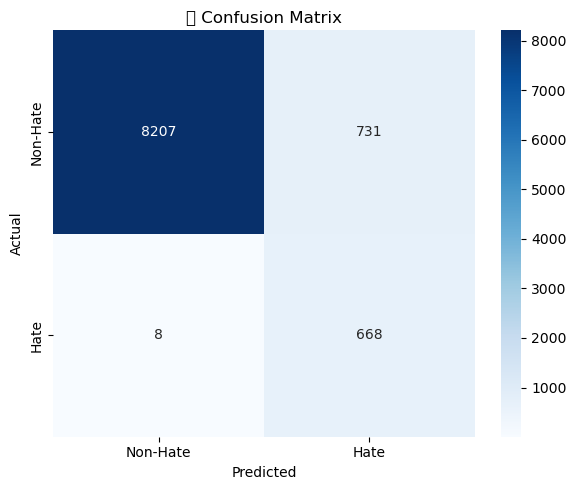

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧾 Classification report
print("📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

# 🔲 Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 📈 Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧩 Confusion Matrix")
plt.tight_layout()
plt.show()


## 🔍 Prediction Confidence Analysis

We now inspect the model's confidence (i.e., softmax probabilities) for each prediction.

This helps us identify:
- Overconfident wrong predictions
- Uncertain borderline cases
- The model’s calibration

We’ll visualize confidence distributions separately for correctly and incorrectly classified examples.


/var/folders/2_/9q4sr54x3z57wwlnq2p2r1jm0000gn/T/ipykernel_64709/2234585066.py:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


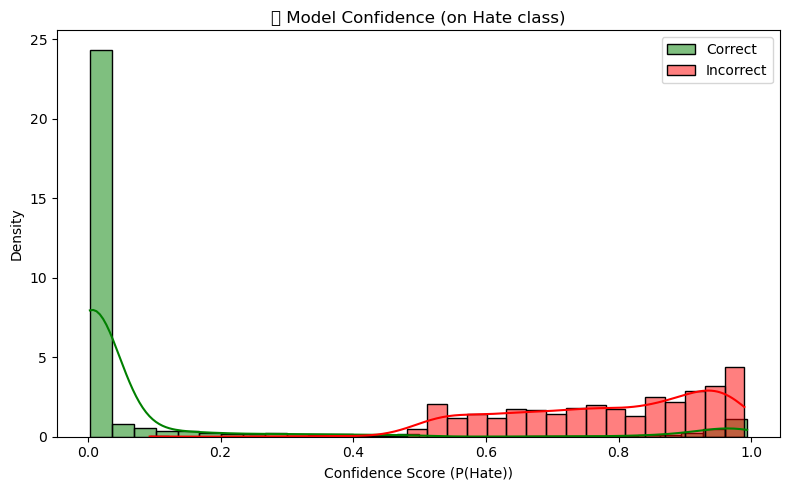

In [5]:
import numpy as np
import torch.nn.functional as F

# 💡 Get softmax scores and labels
probs = []
preds = []
true_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prob = F.softmax(logits, dim=-1)

        probs.extend(prob[:, 1].cpu().numpy())  # probability of class 1 (Hate)
        preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

probs = np.array(probs)
preds = np.array(preds)
true_labels = np.array(true_labels)

# ✅ Create boolean masks
correct = preds == true_labels
incorrect = ~correct

# 📊 Plot distribution of confidence scores
plt.figure(figsize=(8, 5))
sns.histplot(probs[correct], bins=30, color="green", label="Correct", stat="density", kde=True)
sns.histplot(probs[incorrect], bins=30, color="red", label="Incorrect", stat="density", kde=True)
plt.title("🧠 Model Confidence (on Hate class)")
plt.xlabel("Confidence Score (P(Hate))")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import torch
import torch.nn.functional as F

# 🔁 Rebuild test_df with true labels, predicted labels, confidence, and text
logits = []
texts = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits.extend(outputs.logits.cpu().numpy())
        texts.extend(batch["input_ids"].cpu())  # Raw input_ids for reconstruction

# 🔄 Decode input_ids to original text
decoded_texts = tokenizer.batch_decode(texts, skip_special_tokens=True)

# 🧠 Convert logits to predictions + confidence
preds = [torch.tensor(logit).argmax().item() for logit in logits]
conf_hate = [F.softmax(torch.tensor(logit), dim=0)[1].item() for logit in logits]

# 🗃️ Final DataFrame
test_df = pd.DataFrame({
    "text": decoded_texts,
    "true_label": all_labels,
    "predicted_label": preds,
    "confidence_hate": conf_hate,
    "logits": logits
})


In [8]:
false_positives = test_df[
    (test_df['true_label'] == 0) & 
    (test_df['predicted_label'] == 1)
].sort_values(by='confidence_hate', ascending=False)


In [9]:
print("❗ False Positives (Predicted Hate, Actually Not Hate)\n")
false_positives = test_df[
    (test_df['true_label'] == 0) & 
    (test_df['predicted_label'] == 1)
].sort_values(by='confidence_hate', ascending=False)

for i, row in false_positives.head(5).iterrows():
    print(f"🔥 Confidence: {row['confidence_hate']:.2f}")
    print(f"💬 {row['text']}")
    print("-" * 80)


❗ False Positives (Predicted Hate, Actually Not Hate)

🔥 Confidence: 0.99
💬 what did god's will convey to you about defending genocidal maniacs?
--------------------------------------------------------------------------------
🔥 Confidence: 0.99
💬 islamic terrorism is best combated with the help of local muslim communities, especially the families of the would - be radicals. if the muslim families trust the police, they will inform them before their kids do something stupid. most parents ( in canada or anywhere else ) don't want their young sons and daughters blowing themselves up.
--------------------------------------------------------------------------------
🔥 Confidence: 0.99
💬 what a disgusting comment for one who claims to be a catholic priest.
--------------------------------------------------------------------------------
🔥 Confidence: 0.99
💬 once agin you have help enlighten me to a new level of consciousness. thank god i now know about the holley wood & liberals plans praise j

### 📈 ROC Curve and AUC Score

To evaluate how well the model distinguishes between the *hate* and *non-hate* classes at all classification thresholds, we plot the **Receiver Operating Characteristic (ROC)** curve. This is useful to understand the trade-off between true positive and false positive rates.

The **AUC (Area Under Curve)** score provides a single number summarizing performance — closer to `1.0` is better.


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


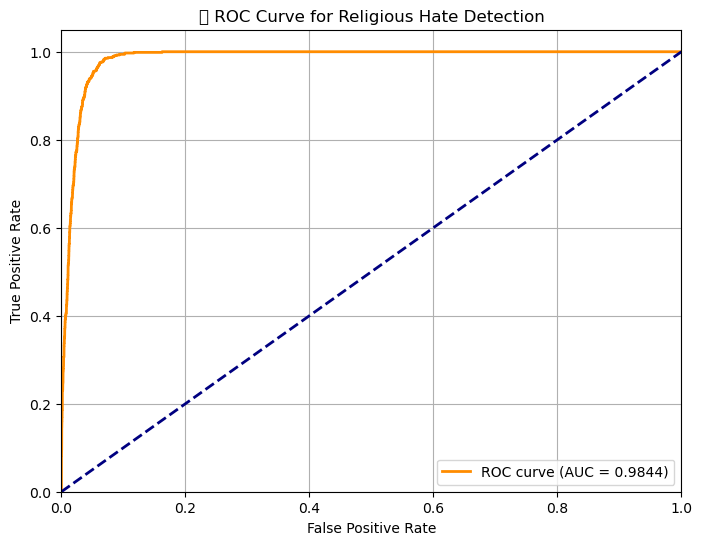

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ✅ True labels and model's confidence for the hate class
true_labels = test_df['true_label']
probs_hate = test_df['confidence_hate']

# ✅ Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, probs_hate)
roc_auc = auc(fpr, tpr)

# 📉 Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📊 ROC Curve for Religious Hate Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### 📉 Precision-Recall Curve

Precision-Recall (PR) curves are particularly useful for evaluating models on **imbalanced classification tasks** — like detecting hate speech — where one class (e.g., "hate") is much less frequent.

Unlike ROC curves, PR curves focus on the performance for the positive class and are more sensitive to **false positives** in the minority class.

We compute the PR curve and the **Average Precision (AP)** score to better understand how confident and accurate the model is when it predicts the "hate" class.


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


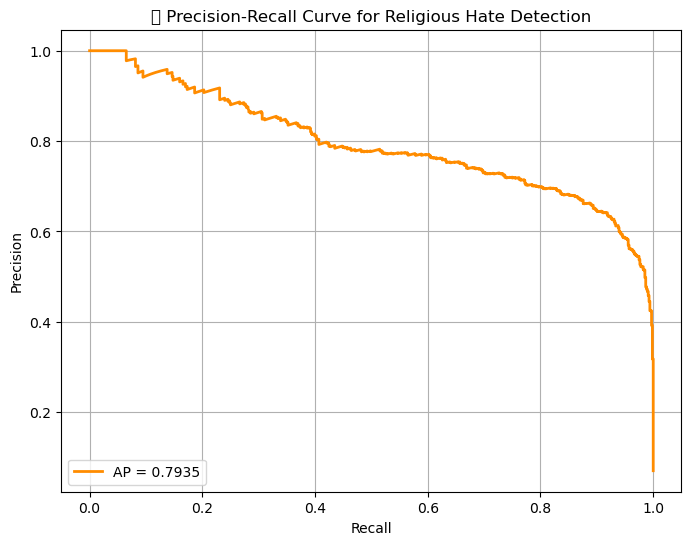

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ✅ Use all_labels and probs from inference
precision, recall, thresholds = precision_recall_curve(all_labels, probs)
ap = average_precision_score(all_labels, probs)

# 📈 Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📉 Precision-Recall Curve for Religious Hate Detection")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


### 📊 Subgroup Evaluation by Religion Keyword

To ensure our model performs fairly across different religions, we break down performance by subgroup. This means evaluating accuracy, precision, recall, and F1-score **for each religion-related keyword** (e.g., "muslim", "jewish", "christian", etc).

This helps us identify whether the model is disproportionately good or bad at detecting hate speech toward specific groups.


In [14]:
import re
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 🧾 Same keywords used earlier
religion_keywords = [
    "muslim", "islam", "islamic", "jew", "jewish", "judaism",
    "christian", "christianity", "bible", "jesus", "god", "catholic", "pope",
    "hindu", "hinduism", "buddha", "buddhist", "atheist", "religion", "religious"
]

# 🧠 Add predicted label and logits to the DataFrame
test_df["label"] = all_labels
test_df["predicted"] = all_preds

# 🧪 Evaluate by keyword
results = []

for keyword in religion_keywords:
    mask = test_df["text"].str.lower().str.contains(rf"\b{keyword}\b", regex=True)
    subgroup = test_df[mask]

    if len(subgroup) < 10:
        continue  # Skip tiny subgroups to avoid noise

    acc = accuracy_score(subgroup["label"], subgroup["predicted"])
    prec = precision_score(subgroup["label"], subgroup["predicted"], zero_division=0)
    rec = recall_score(subgroup["label"], subgroup["predicted"], zero_division=0)
    f1 = f1_score(subgroup["label"], subgroup["predicted"], zero_division=0)

    results.append({
        "Keyword": keyword,
        "Samples": len(subgroup),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3)
    })

# 📊 Display results
import pandas as pd
subgroup_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
subgroup_df.reset_index(drop=True, inplace=True)
subgroup_df


,Keyword,Samples,Accuracy,Precision,Recall,F1
0,judaism,43,0.977,0.857,1.000,0.923
1,buddha,15,0.933,0.667,1.000,0.800
2,islam,543,0.877,0.547,1.000,0.707
3,jesus,1120,0.959,0.535,1.000,0.697
4,jewish,320,0.919,0.519,1.000,0.683
5,jew,102,0.843,0.500,1.000,0.667
6,religion,1271,0.932,0.500,1.000,0.667
7,islamic,443,0.874,0.491,1.000,0.659
8,christianity,271,0.908,0.490,1.000,0.658
9,christian,975,0.918,0.494,0.974,0.655
